In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import random
import einops

from typing import Dict, List, Tuple, Callable
from torch import Tensor
from jaxtyping import Float, Int
from transformer_lens import HookedTransformer

/root/iclr/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_grad_enabled(False)

In [3]:
def set_seed(seed: int):
    torch.random.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [4]:
model = HookedTransformer.from_pretrained_no_processing('meta-llama/Llama-3.1-8B', device='cuda')

Loading checkpoint shards: 100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


In [5]:
class Grid:
    def __init__(self, words, rows, cols):
        n_words = len(words)
        
        if rows * cols != n_words:
            raise ValueError(f"Grid dimensions ({rows}x{cols}={rows*cols}) do not match number of words ({n_words})")

        self.words = words
        self.rows = rows
        self.cols = cols
        self.grid = np.array(words).reshape(self.rows, self.cols).tolist()

        self.word_to_col = {word: i % cols for i, word in enumerate(words)}
        self.word_to_row = {word: i // cols for i, word in enumerate(words)}

    def generate_sequence(self, seq_len):
        sequence = []

        row, col = np.random.randint(0, self.rows), np.random.randint(0, self.cols)
        sequence.append(self.grid[row][col])

        while len(sequence) < seq_len:
            valid_moves = self._get_valid_moves(row, col)

            direction = np.random.choice(valid_moves)
            if direction == 'up':
                row -= 1
            elif direction == 'down':
                row += 1
            elif direction == 'left':
                col -= 1
            elif direction == 'right':
                col += 1

            sequence.append(self.grid[row][col])

        return sequence
    
    def get_valid_next_words(self, word):
        row, col = self.word_to_row[word], self.word_to_col[word]
        return self._get_valid_next_words_from_position(row, col)
    
    def _get_valid_next_words_from_position(self, row, col):
        valid_moves = self._get_valid_moves(row, col)
        next_words = []
        for move in valid_moves:
            if move == 'up':
                next_words.append(self.grid[row-1][col])
            elif move == 'down':
                next_words.append(self.grid[row+1][col])
            elif move == 'left':
                next_words.append(self.grid[row][col-1])
            elif move == 'right':
                next_words.append(self.grid[row][col+1])
        return next_words
    
    def _get_valid_moves(self, row, col):
        valid_moves = []
        if row > 0: valid_moves.append('up')
        if row < self.rows - 1: valid_moves.append('down')
        if col > 0: valid_moves.append('left')
        if col < self.cols - 1: valid_moves.append('right')
        return valid_moves

In [6]:
words = ['apple', 'bird', 'car', 'egg','house', 'milk', 'plane', 'opera', 'box', 'sand', 'sun', 'mango', 'rock', 'math', 'code', 'phone']

## Induction heads

In [7]:
set_seed(0)
random_tokens = torch.randint(low=0, high=model.cfg.d_vocab//2, size=(64,))
random_tokens_repeated = torch.cat([random_tokens] * 2, dim=0)

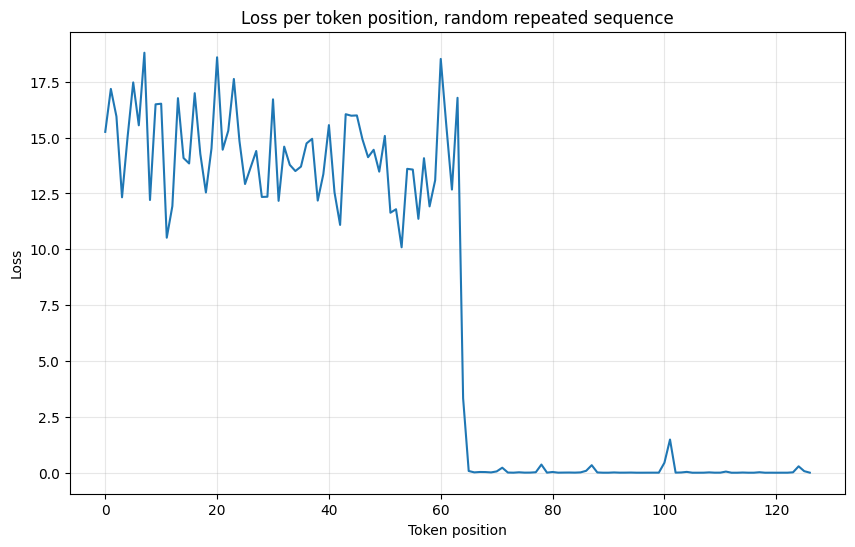

In [8]:
logits = model(random_tokens_repeated.to(model.cfg.device))
log_probs = torch.log_softmax(logits, dim=-1).to('cpu')

loss_per_token = torch.gather(input=-log_probs[0, :-1, :], dim=-1, index=random_tokens_repeated[1:].unsqueeze(-1))

plt.figure(figsize=(10, 6))
plt.plot(loss_per_token.flatten().numpy())
plt.grid(True, alpha=0.3)
plt.xlabel('Token position')
plt.ylabel('Loss')
plt.title('Loss per token position, random repeated sequence')

plt.show()

In [9]:
name_filters = [f'blocks.{layer}.attn.hook_pattern' for layer in range(model.cfg.n_layers)]

_, cache = model.run_with_cache(random_tokens_repeated, names_filter=name_filters)

In [10]:
def induction_head_score(pattern: Float[Tensor, "seq seq"]) -> float:
    seq, _ = pattern.shape
    offset = (seq//2) - 1 # (128//2) - 1 = 63: we want position 63 to be looking back to position 0, in order to move position 0 to position 64

    return pattern.diagonal(offset=-offset).mean()

In [11]:
layer_to_head_to_score = {}
for layer in range(model.cfg.n_layers):
    layer_to_head_to_score[layer] = {}
    for head in range(model.cfg.n_heads):
        pattern = cache[f'blocks.{layer}.attn.hook_pattern'][0, head]
        layer_to_head_to_score[layer][head] = induction_head_score(pattern)

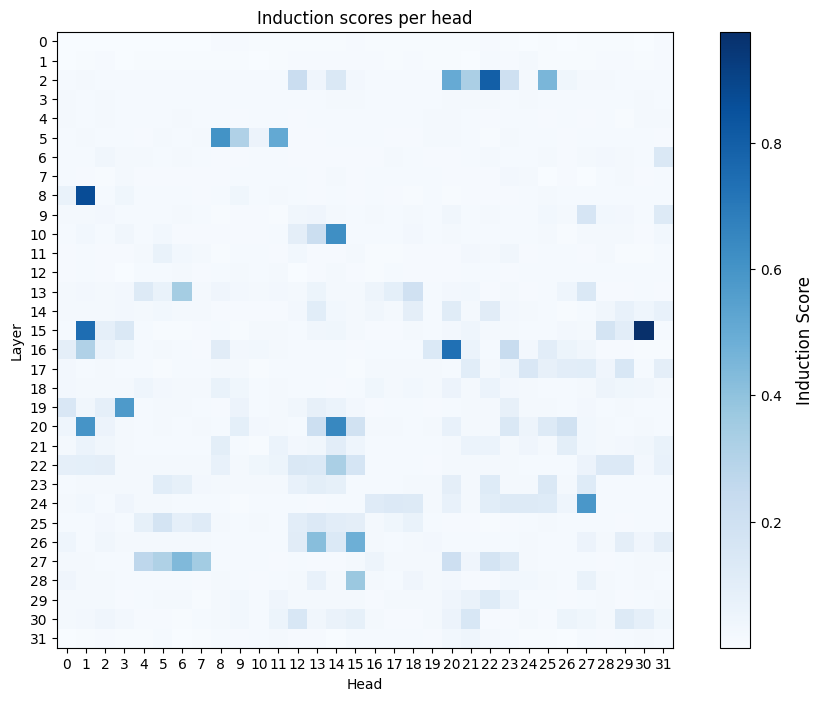

In [12]:
# Convert dictionary to numpy array for plotting
scores = np.zeros((model.cfg.n_layers, model.cfg.n_heads))
for layer in range(model.cfg.n_layers):
    for head in range(model.cfg.n_heads):
        scores[layer, head] = layer_to_head_to_score[layer][head]

plt.figure(figsize=(12, 8))
im = plt.imshow(scores, cmap='Blues')
cbar = plt.colorbar(im)
cbar.set_label('Induction Score', fontsize=12, labelpad=10)
plt.xlabel('Head')
plt.ylabel('Layer')
plt.title('Induction scores per head')
plt.xticks(range(model.cfg.n_heads))
plt.yticks(range(model.cfg.n_layers))
plt.show()

In [13]:
# Create list of (score, layer, head) tuples
induction_scores_as_list = [
    (layer_to_head_to_score[layer][head], layer, head) 
    for layer in range(model.cfg.n_layers) 
    for head in range(model.cfg.n_heads)
]

# Sort by score (first element of tuple)
induction_scores_as_list.sort(key=lambda x: x[0], reverse=True)

k = 20
print(f"Top {k} induction heads:")
for score, layer, head in induction_scores_as_list[:k]:
    print(f"Layer {layer}, Head {head}: {score:.3f}")

Top 20 induction heads:
Layer 15, Head 30: 0.976
Layer 8, Head 1: 0.867
Layer 2, Head 22: 0.798
Layer 15, Head 1: 0.746
Layer 16, Head 20: 0.732
Layer 20, Head 14: 0.648
Layer 10, Head 14: 0.621
Layer 5, Head 8: 0.604
Layer 20, Head 1: 0.597
Layer 24, Head 27: 0.584
Layer 19, Head 3: 0.573
Layer 5, Head 11: 0.511
Layer 2, Head 20: 0.503
Layer 26, Head 15: 0.484
Layer 2, Head 25: 0.452
Layer 27, Head 6: 0.437
Layer 26, Head 13: 0.416
Layer 28, Head 15: 0.372
Layer 27, Head 7: 0.350
Layer 13, Head 6: 0.344


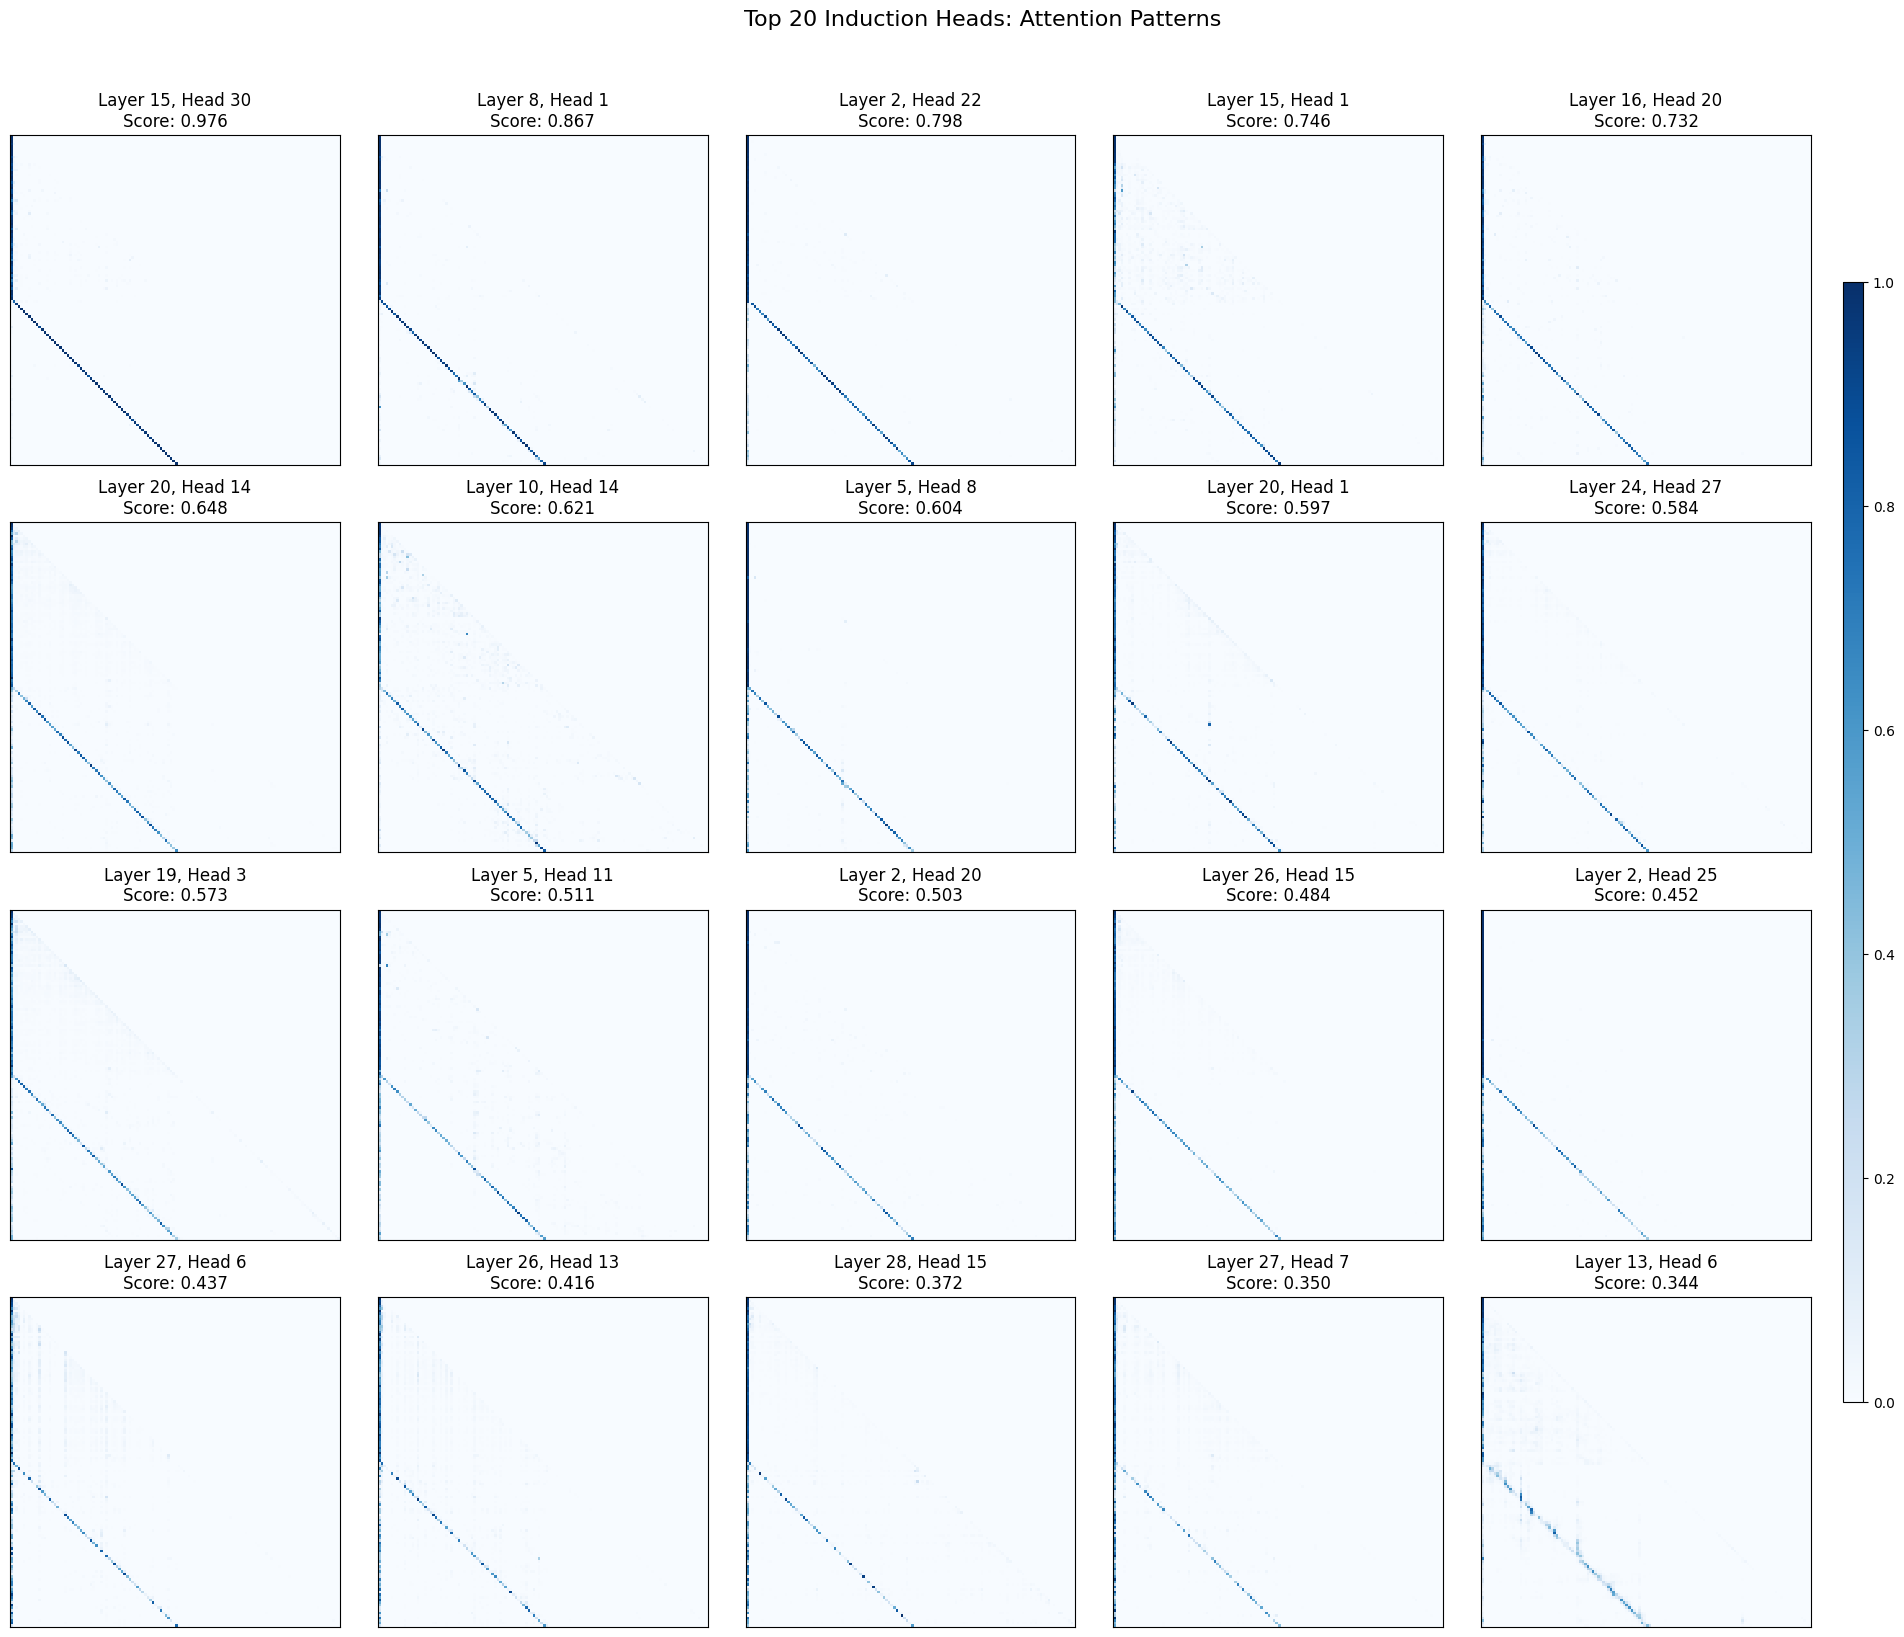

In [14]:
# Create a 4x5 grid of subplots for top 20 heads
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
fig.suptitle("Top 20 Induction Heads: Attention Patterns", fontsize=16, y=1.02)

# Plot each attention pattern
for idx, (score, layer, head) in enumerate(induction_scores_as_list[:20]):
    row = idx // 5
    col = idx % 5
    
    pattern = cache[f'blocks.{layer}.attn.hook_pattern'][0, head]
    
    # Plot attention pattern
    im = axes[row, col].imshow(
        pattern.cpu(),
        cmap='Blues',
        interpolation='nearest'
    )
    
    # Add title with layer, head, and score information
    axes[row, col].set_title(f'Layer {layer}, Head {head}\nScore: {score:.3f}')
    
    # Remove ticks for cleaner look
    axes[row, col].set_xticks([])
    axes[row, col].set_yticks([])

# Add a colorbar that applies to all subplots
plt.tight_layout()
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [15]:
from transformer_lens.hook_points import HookPoint
from transformer_lens import ActivationCache

def activation_ablation_hook(
    activation: Float[Tensor, "batch seq d_activation"],
    hook: HookPoint,
) -> Float[Tensor, "batch seq d_activation"]:
    activation[:, :, :] = torch.zeros_like(activation[:, :, :])
    return activation

def head_ablation_hook(
    activation: Float[Tensor, "batch seq n_heads d_activation"],
    hook: HookPoint,
    head: int,
) -> Float[Tensor, "batch seq n_heads d_activation"]:
    activation[:, :, head, :] = torch.zeros_like(activation[:, :, head, :])
    return activation

In [16]:
def get_repeated_token_loss(repeated_tokens: Int[Tensor, "batch seq"], logits: Float[Tensor, "batch seq d_vocab"]) -> Float[Tensor, "batch"]:
    log_probs = torch.log_softmax(logits, dim=-1).to(repeated_tokens.device)
    loss_per_token = torch.gather(input=-log_probs[0, :-1, :], dim=-1, index=repeated_tokens[1:].unsqueeze(-1))
    return loss_per_token.flatten()[log_probs.shape[1]//2:].mean()

In [17]:
import functools
from transformer_lens import utils

activation_type = "z"

patching_metrics = []
for n_heads_to_ablate in range(0, 50):
    heads_to_ablate = [(layer, head) for _, layer, head in induction_scores_as_list[:n_heads_to_ablate]]

    fwd_hooks = [(utils.get_act_name(activation_type, layer), functools.partial(head_ablation_hook, head=head)) for layer, head in heads_to_ablate]
    logits = model.run_with_hooks(random_tokens_repeated, fwd_hooks=fwd_hooks)
    metric = get_repeated_token_loss(random_tokens_repeated, logits)
    patching_metrics.append(metric)

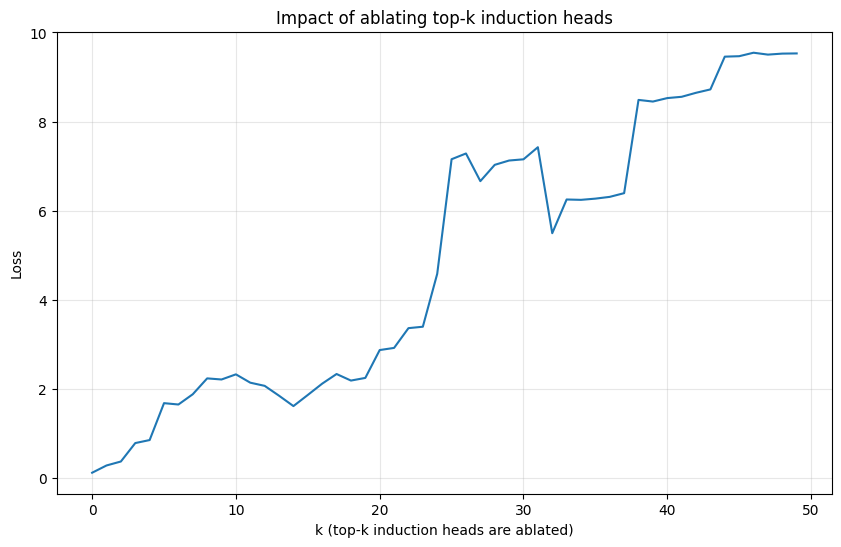

In [18]:
# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(patching_metrics)
plt.xlabel('k (top-k induction heads are ablated)')
plt.ylabel('Loss')
plt.title('Impact of ablating top-k induction heads')
plt.grid(True, alpha=0.3)
plt.show()

## Previous token heads

In [19]:
set_seed(0)
random_tokens = torch.randint(low=0, high=model.cfg.d_vocab//2, size=(64,))
random_tokens_repeated = torch.cat([random_tokens] * 2, dim=0)

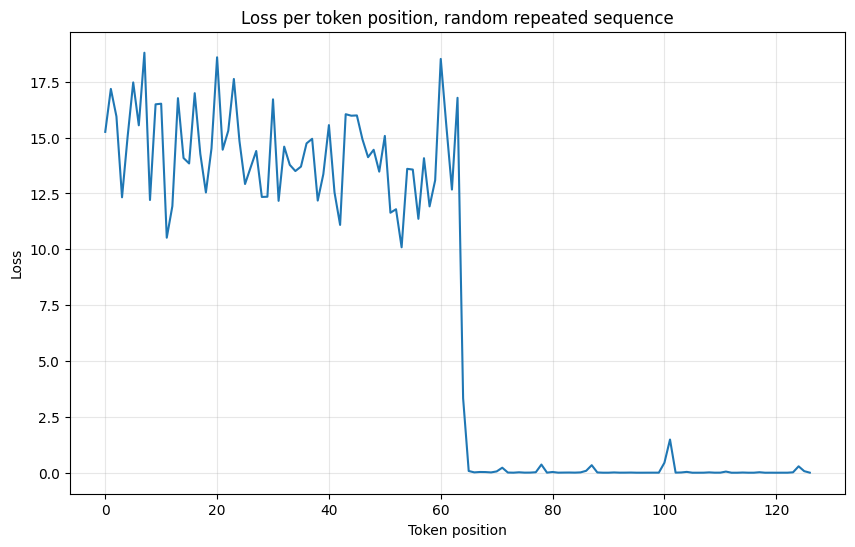

In [20]:
logits = model(random_tokens_repeated.to(model.cfg.device))
log_probs = torch.log_softmax(logits, dim=-1).to('cpu')

loss_per_token = torch.gather(input=-log_probs[0, :-1, :], dim=-1, index=random_tokens_repeated[1:].unsqueeze(-1))

plt.figure(figsize=(10, 6))
plt.plot(loss_per_token.flatten().numpy())
plt.grid(True, alpha=0.3)
plt.xlabel('Token position')
plt.ylabel('Loss')
plt.title('Loss per token position, random repeated sequence')

plt.show()

In [21]:
name_filters = [f'blocks.{layer}.attn.hook_pattern' for layer in range(model.cfg.n_layers)]

_, cache = model.run_with_cache(random_tokens_repeated, names_filter=name_filters)

In [22]:
def previous_token_head_score(pattern: Float[Tensor, "seq seq"]) -> float:
    seq, _ = pattern.shape

    return pattern.diagonal(offset=-1).mean()

In [23]:
layer_to_head_to_previous_token_head_score = {}
for layer in range(model.cfg.n_layers):
    layer_to_head_to_previous_token_head_score[layer] = {}
    for head in range(model.cfg.n_heads):
        pattern = cache[f'blocks.{layer}.attn.hook_pattern'][0, head]
        layer_to_head_to_previous_token_head_score[layer][head] = previous_token_head_score(pattern)

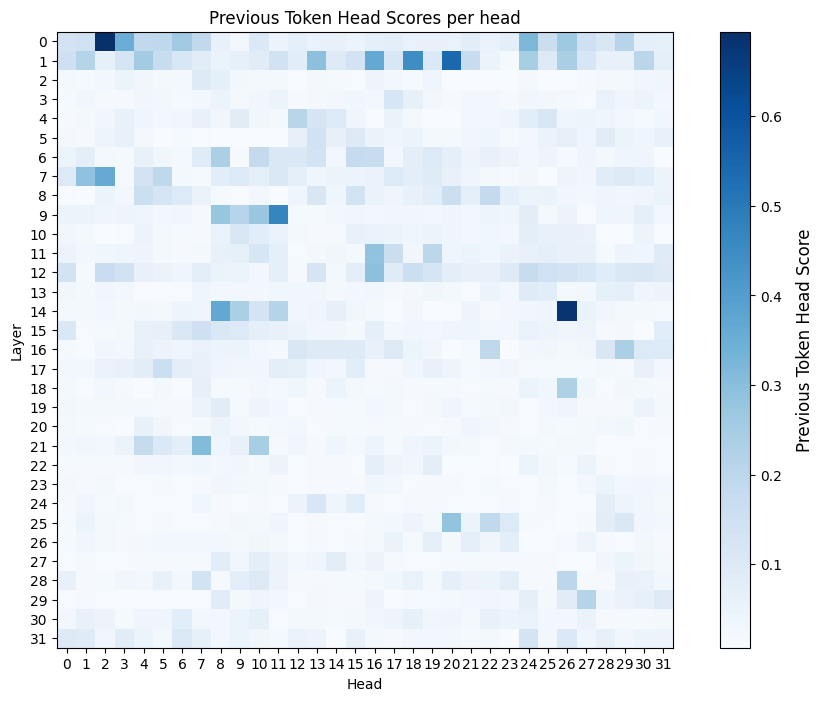

In [24]:
# Convert dictionary to numpy array for plotting
scores = np.zeros((model.cfg.n_layers, model.cfg.n_heads))
for layer in range(model.cfg.n_layers):
    for head in range(model.cfg.n_heads):
        scores[layer, head] = layer_to_head_to_previous_token_head_score[layer][head]

plt.figure(figsize=(12, 8))
im = plt.imshow(scores, cmap='Blues')
cbar = plt.colorbar(im)
cbar.set_label('Previous Token Head Score', fontsize=12, labelpad=10)
plt.xlabel('Head')
plt.ylabel('Layer')
plt.title('Previous Token Head Scores per head')
plt.xticks(range(model.cfg.n_heads))
plt.yticks(range(model.cfg.n_layers))
plt.show()

In [25]:
# Create list of (score, layer, head) tuples
previous_token_head_scores_as_list = [
    (layer_to_head_to_previous_token_head_score[layer][head], layer, head) 
    for layer in range(model.cfg.n_layers) 
    for head in range(model.cfg.n_heads)
]

# Sort by score (first element of tuple)
previous_token_head_scores_as_list.sort(key=lambda x: x[0], reverse=True)

k = 20
print(f"Top {k} previous token heads:")
for score, layer, head in previous_token_head_scores_as_list[:k]:
    print(f"Layer {layer}, Head {head}: {score:.3f}")

Top 20 previous token heads:
Layer 0, Head 2: 0.694
Layer 14, Head 26: 0.683
Layer 1, Head 20: 0.546
Layer 9, Head 11: 0.468
Layer 1, Head 18: 0.447
Layer 14, Head 8: 0.369
Layer 1, Head 16: 0.365
Layer 7, Head 2: 0.360
Layer 0, Head 3: 0.353
Layer 0, Head 24: 0.320
Layer 21, Head 7: 0.308
Layer 12, Head 16: 0.294
Layer 1, Head 13: 0.293
Layer 7, Head 1: 0.288
Layer 11, Head 16: 0.285
Layer 25, Head 20: 0.283
Layer 9, Head 8: 0.277
Layer 9, Head 10: 0.271
Layer 0, Head 26: 0.264
Layer 0, Head 6: 0.257


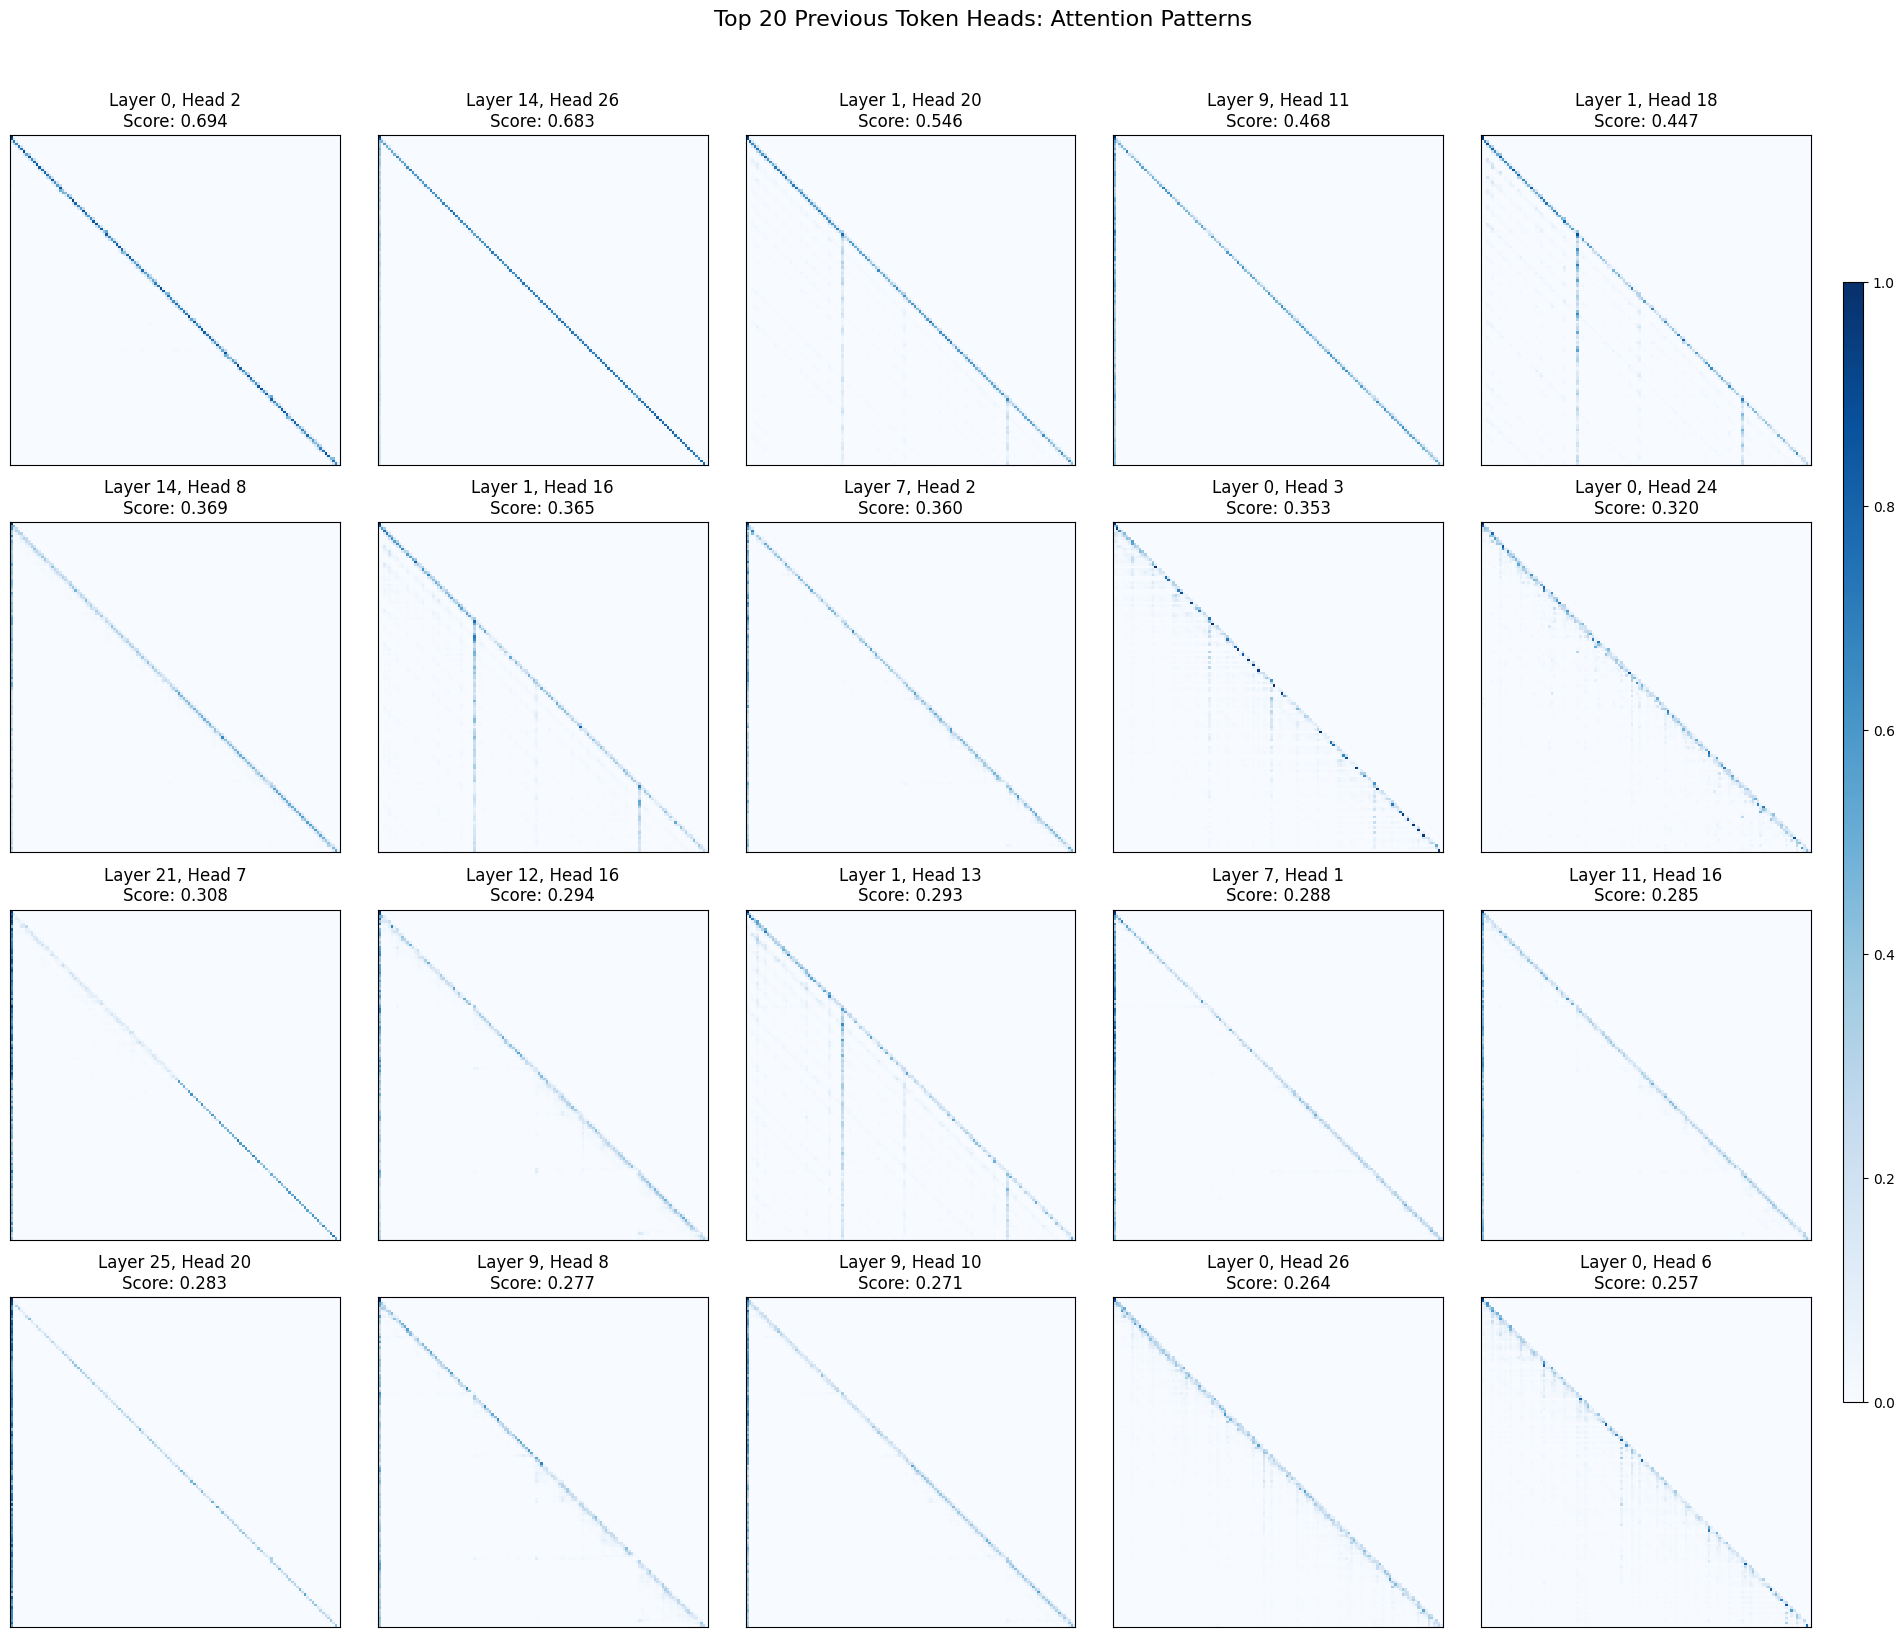

In [26]:
# Create a 4x5 grid of subplots for top 20 heads
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
fig.suptitle("Top 20 Previous Token Heads: Attention Patterns", fontsize=16, y=1.02)

# Plot each attention pattern
for idx, (score, layer, head) in enumerate(previous_token_head_scores_as_list[:20]):
    row = idx // 5
    col = idx % 5
    
    pattern = cache[f'blocks.{layer}.attn.hook_pattern'][0, head]
    
    # Plot attention pattern
    im = axes[row, col].imshow(
        pattern.cpu(),
        cmap='Blues',
        interpolation='nearest'
    )
    
    # Add title with layer, head, and score information
    axes[row, col].set_title(f'Layer {layer}, Head {head}\nScore: {score:.3f}')
    
    # Remove ticks for cleaner look
    axes[row, col].set_xticks([])
    axes[row, col].set_yticks([])

# Add a colorbar that applies to all subplots
plt.tight_layout()
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## Grid task

In [27]:
grid = Grid(words, rows=4, cols=4)

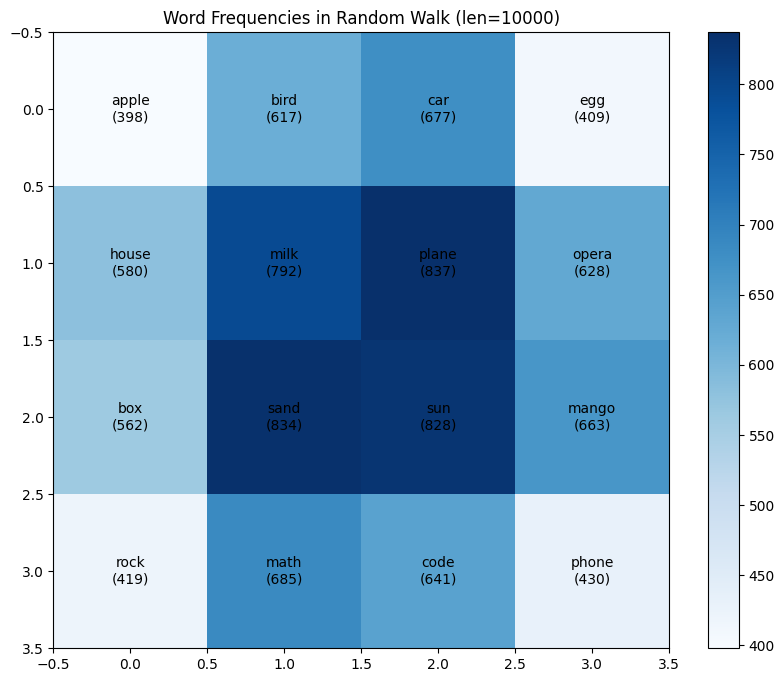

In [28]:
N_STEPS = 10_000

sequence = grid.generate_sequence(N_STEPS)

# histogram of word frequencies:
word_freq = {}
for word in sequence:
    if word in word_freq:
        word_freq[word] += 1
    else:
        word_freq[word] = 1

# Create a 2D array of frequencies matching the grid layout
freq_grid = np.zeros((grid.rows, grid.cols))
for i, row in enumerate(grid.grid):
    for j, word in enumerate(row):
        freq_grid[i][j] = word_freq.get(word, 0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(freq_grid, cmap='Blues', interpolation='nearest')
plt.colorbar()

# Add word labels to each cell
for i in range(grid.rows):
    for j in range(grid.cols):
        plt.text(j, i, f'{grid.grid[i][j]}\n({int(freq_grid[i][j])})', 
                ha='center', va='center')
        

plt.title(f'Word Frequencies in Random Walk (len={N_STEPS})')
plt.show()


In [29]:
def tokenize_sequence(sequence: list[str]) -> torch.Tensor:
    sequence_as_string = ' ' + ' '.join(sequence)
    return model.tokenizer(sequence_as_string, return_tensors='pt').input_ids

In [30]:
sequence = grid.generate_sequence(10)

tokens = tokenize_sequence(sequence)
model.to_str_tokens(tokens)

['<|begin_of_text|>',
 ' box',
 ' house',
 ' box',
 ' house',
 ' milk',
 ' sand',
 ' box',
 ' house',
 ' apple',
 ' bird']

## Check impact of ablating induction heads on grid task performance

In [31]:
def get_model_accuracies(sequence: list[str], fwd_hooks: list[tuple[str, Callable]] = []):
    tokens = tokenize_sequence(sequence)
    logits = model.run_with_hooks(tokens.to(model.cfg.device), fwd_hooks=fwd_hooks)
    probs = torch.softmax(logits, dim=-1)
    probs = probs[0, 1:, :] # shave off bos token

    accuracies = []

    for i in range(len(sequence)):
        valid_next_words = grid.get_valid_next_words(sequence[i])
        valid_next_word_token_ids = torch.tensor([model.tokenizer.encode(' ' + w, add_special_tokens=False) for w in valid_next_words]).squeeze()
        accuracy = probs[i, valid_next_word_token_ids].sum().item()
        accuracies.append(accuracy)

    return accuracies

In [53]:
SEQ_LEN = 1400
ITERS = 10
SEED = 0

In [54]:
n_heads_to_ablate_list = [0, 1, 2, 3, 5, 10, 20]

ablation_accuracies = []

for n_heads_to_ablate in n_heads_to_ablate_list:
    heads_to_ablate = [(layer, head) for _, layer, head in induction_scores_as_list[:n_heads_to_ablate]]
    fwd_hooks = [(utils.get_act_name(activation_type, layer), functools.partial(head_ablation_hook, head=head)) for layer, head in heads_to_ablate]
    
    set_seed(SEED)
    accuracies = []
    for iterations in tqdm.tqdm(range(ITERS)):
        accuracies.append(get_model_accuracies(grid.generate_sequence(SEQ_LEN), fwd_hooks=fwd_hooks))

    ablation_accuracies.append(accuracies)


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


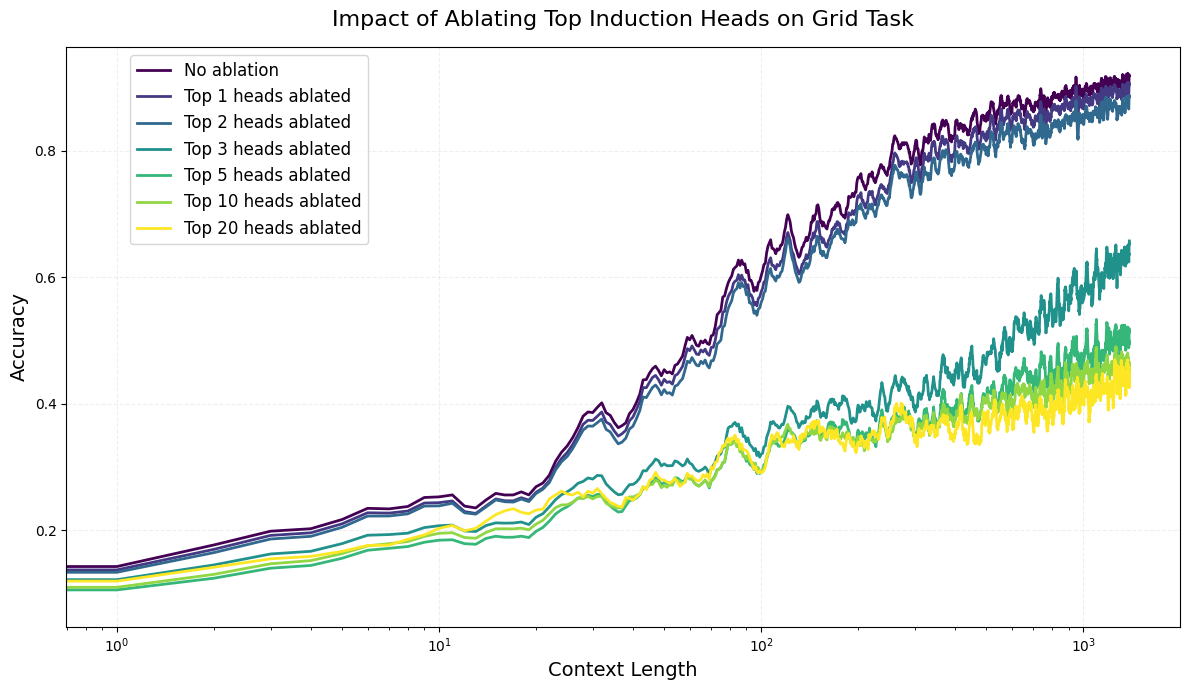

In [56]:
import matplotlib.cm as cm

plt.figure(figsize=(12, 7))

# Create color gradient
colors = cm.viridis(np.linspace(0, 1, len(n_heads_to_ablate_list)))

# Plot each condition
for i, n_heads in enumerate(n_heads_to_ablate_list):
    mean_acc = np.array(ablation_accuracies[i]).mean(axis=0)
    label = 'No ablation' if n_heads == 0 else f'Top {n_heads} heads ablated'
    
    # Apply smoothing
    window = 10
    smoothed = np.convolve(mean_acc, np.ones(window)/window, mode='valid')
    
    plt.plot(smoothed, label=label, color=colors[i], linewidth=2)

plt.xscale('log')
plt.xlabel('Context Length', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Impact of Ablating Top Induction Heads on Grid Task', fontsize=16, pad=15)

# Customize grid
plt.grid(True, alpha=0.2, linestyle='--')

# Move legend outside
plt.legend(fontsize=12, bbox_to_anchor=(0.05, 1), loc='upper left')

# Add some padding to prevent label cutoff
plt.tight_layout()
plt.show()

## Check impact of ablating previous token heads on grid task performance

In [57]:
SEQ_LEN = 1400
ITERS = 10
SEED = 0

In [58]:
n_heads_to_ablate_list = [0, 1, 2, 3, 5, 10, 20]

ablation_accuracies = []

for n_heads_to_ablate in n_heads_to_ablate_list:
    heads_to_ablate = [(layer, head) for _, layer, head in previous_token_head_scores_as_list[:n_heads_to_ablate]]
    fwd_hooks = [(utils.get_act_name(activation_type, layer), functools.partial(head_ablation_hook, head=head)) for layer, head in heads_to_ablate]
    
    set_seed(SEED)
    accuracies = []
    for iterations in tqdm.tqdm(range(ITERS)):
        accuracies.append(get_model_accuracies(grid.generate_sequence(SEQ_LEN), fwd_hooks=fwd_hooks))

    ablation_accuracies.append(accuracies)


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


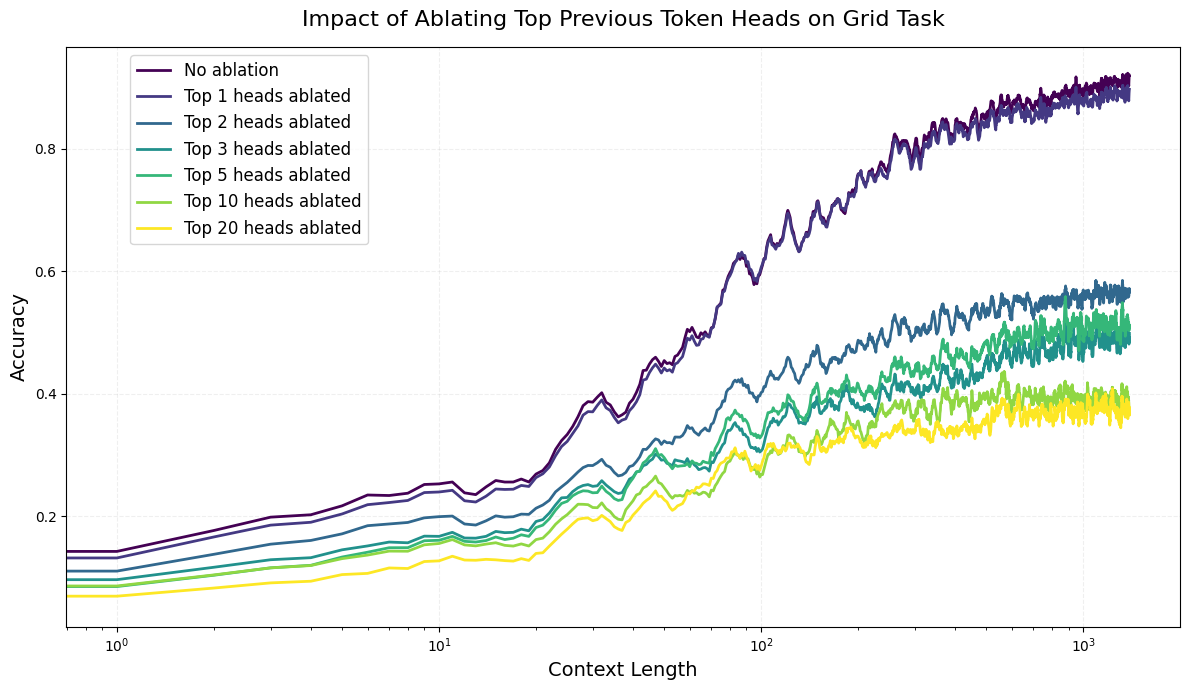

In [59]:
import matplotlib.cm as cm

plt.figure(figsize=(12, 7))

# Create color gradient
colors = cm.viridis(np.linspace(0, 1, len(n_heads_to_ablate_list)))

# Plot each condition
for i, n_heads in enumerate(n_heads_to_ablate_list):
    mean_acc = np.array(ablation_accuracies[i]).mean(axis=0)
    label = 'No ablation' if n_heads == 0 else f'Top {n_heads} heads ablated'
    
    # Apply smoothing
    window = 10
    smoothed = np.convolve(mean_acc, np.ones(window)/window, mode='valid')
    
    plt.plot(smoothed, label=label, color=colors[i], linewidth=2)

plt.xscale('log')
plt.xlabel('Context Length', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Impact of Ablating Top Previous Token Heads on Grid Task', fontsize=16, pad=15)

# Customize grid
plt.grid(True, alpha=0.2, linestyle='--')

# Move legend outside
plt.legend(fontsize=12, bbox_to_anchor=(0.05, 1), loc='upper left')

# Add some padding to prevent label cutoff
plt.tight_layout()
plt.show()

## Baseline: ablate random heads

In [61]:
SEQ_LEN = 1400
ITERS = 10
SEED = 0

In [62]:
n_heads_to_ablate_list = [0, 1, 2, 3, 5, 10, 20]

ablation_accuracies = []

for n_heads_to_ablate in n_heads_to_ablate_list:
    set_seed(SEED)
    accuracies = []
    for iterations in tqdm.tqdm(range(ITERS)):
        heads_to_ablate = [(layer, head) for _, layer, head in random.sample(induction_scores_as_list, n_heads_to_ablate)]
        fwd_hooks = [(utils.get_act_name(activation_type, layer), functools.partial(head_ablation_hook, head=head)) for layer, head in heads_to_ablate]
        accuracies.append(get_model_accuracies(grid.generate_sequence(SEQ_LEN), fwd_hooks=fwd_hooks))

    ablation_accuracies.append(accuracies)


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


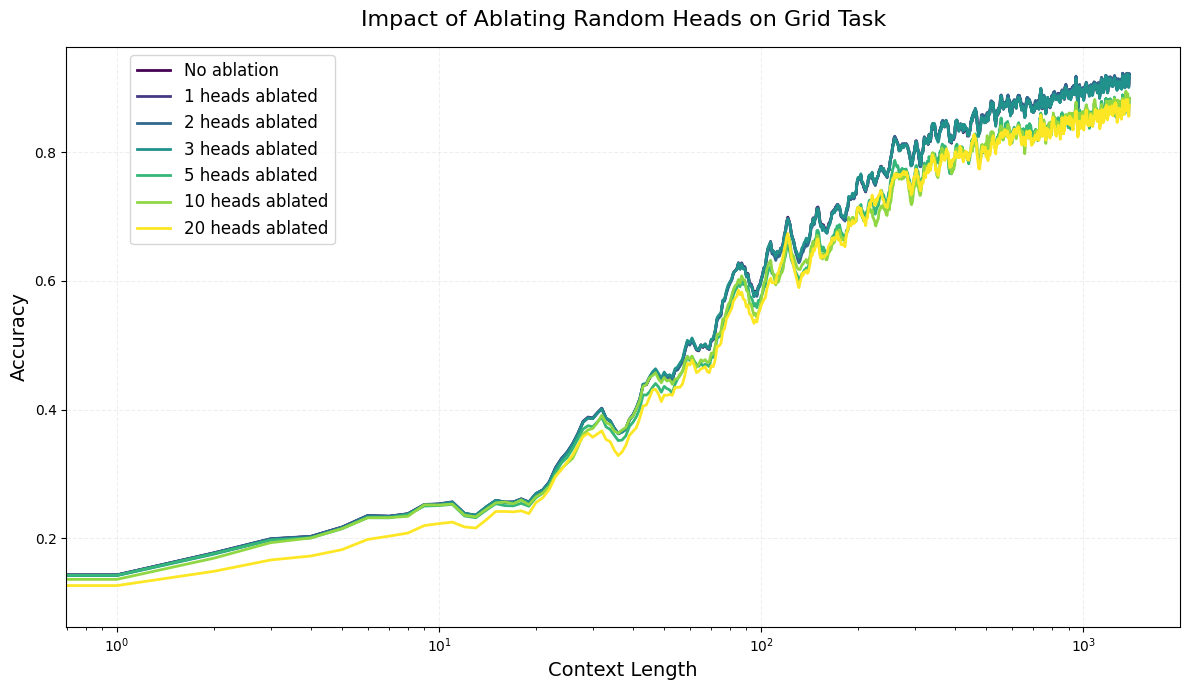

In [64]:
import matplotlib.cm as cm

plt.figure(figsize=(12, 7))

# Create color gradient
colors = cm.viridis(np.linspace(0, 1, len(n_heads_to_ablate_list)))

# Plot each condition
for i, n_heads in enumerate(n_heads_to_ablate_list):
    mean_acc = np.array(ablation_accuracies[i]).mean(axis=0)
    label = 'No ablation' if n_heads == 0 else f'{n_heads} heads ablated'
    
    # Apply smoothing
    window = 10
    smoothed = np.convolve(mean_acc, np.ones(window)/window, mode='valid')
    
    plt.plot(smoothed, label=label, color=colors[i], linewidth=2)

plt.xscale('log')
plt.xlabel('Context Length', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Impact of Ablating Random Heads on Grid Task', fontsize=16, pad=15)

# Customize grid
plt.grid(True, alpha=0.2, linestyle='--')

# Move legend outside
plt.legend(fontsize=12, bbox_to_anchor=(0.05, 1), loc='upper left')

# Add some padding to prevent label cutoff
plt.tight_layout()
plt.show()

## View representations when heads are ablated

In [65]:
def get_activations(sequence: list[str], n_lookback: int, layers: list[int], mean_centered: bool = True, fwd_hooks: list[tuple[str, Callable]] = []):
    tokens = tokenize_sequence(sequence)
    names_filter = [f'blocks.{layer}.hook_resid_pre' for layer in layers]

    with model.hooks(fwd_hooks=fwd_hooks):
        _, cache = model.run_with_cache(tokens.to(model.cfg.device), names_filter=names_filter)

    layer_to_acts = {}

    for layer in layers:
        cache_key = f'blocks.{layer}.hook_resid_pre'
        layer_to_acts[layer] = cache[cache_key][0, -n_lookback:, :]

    if mean_centered:
        layer_to_acts = {layer: acts - acts.mean(dim=0, keepdim=True) for layer, acts in layer_to_acts.items()}
    
    return layer_to_acts

def get_pca_directions(acts: Float[Tensor, "ctx d_model"], top_n: int = 2):
    acts_centered = acts - acts.mean(dim=0, keepdim=True)
    _, _, V = torch.svd(acts_centered)
    return einops.rearrange(V, 'd_model n -> n d_model')[:top_n, :]

In [66]:
def visualize_pca(
    sequence: list[str],
    acts: torch.Tensor,
    pca_directions: torch.Tensor,
    n_lookback: int,
    plot_title: str,
):
    plt.figure(figsize=(12, 8))

    # Define distinct colors for words
    distinct_colors = {
        word: color for word, color in zip(grid.words, [
            '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', 
            '#ffff33', '#a65628', '#f781bf', '#999999', '#66c2a5', 
            '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494'
        ])
    }

    # Project activations
    projected = acts @ pca_directions.T
    
    # Get word-averaged positions
    word_to_avg_pos = {}
    for word in grid.words:
        word_indices = [i for i, w in enumerate(sequence[-n_lookback:]) if w == word]
        if word_indices:  # only if we have instances of this word
            word_points = projected[word_indices]
            word_to_avg_pos[word] = word_points.mean(dim=0).cpu()

    # Draw grid connections
    for word in word_to_avg_pos:
        connected_words = grid.get_valid_next_words(word)
        start_pos = word_to_avg_pos[word]
        for next_word in connected_words:
            if next_word in word_to_avg_pos:
                end_pos = word_to_avg_pos[next_word]
                plt.plot([start_pos[0], end_pos[0]], 
                        [start_pos[1], end_pos[1]], 
                        color='gray', alpha=0.3, linestyle='--')

    # Plot points and averages
    for word in word_to_avg_pos:
        word_indices = [i for i, w in enumerate(sequence[-n_lookback:]) if w == word]
        word_points = projected[word_indices]
        
        # Plot individual points
        plt.scatter(word_points[:, 0].cpu(), 
                   word_points[:, 1].cpu(), 
                   color=distinct_colors[word],
                   alpha=0.4,
                   s=30)
        
        # Plot and annotate average
        avg_point = word_to_avg_pos[word]
        plt.scatter(avg_point[0], 
                   avg_point[1], 
                   color=distinct_colors[word],
                   s=200,
                   marker='*',
                   edgecolors='black',
                   linewidth=1.5)
        
        plt.annotate(word, 
                    (avg_point[0], avg_point[1]),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=8,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    plt.title(plot_title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

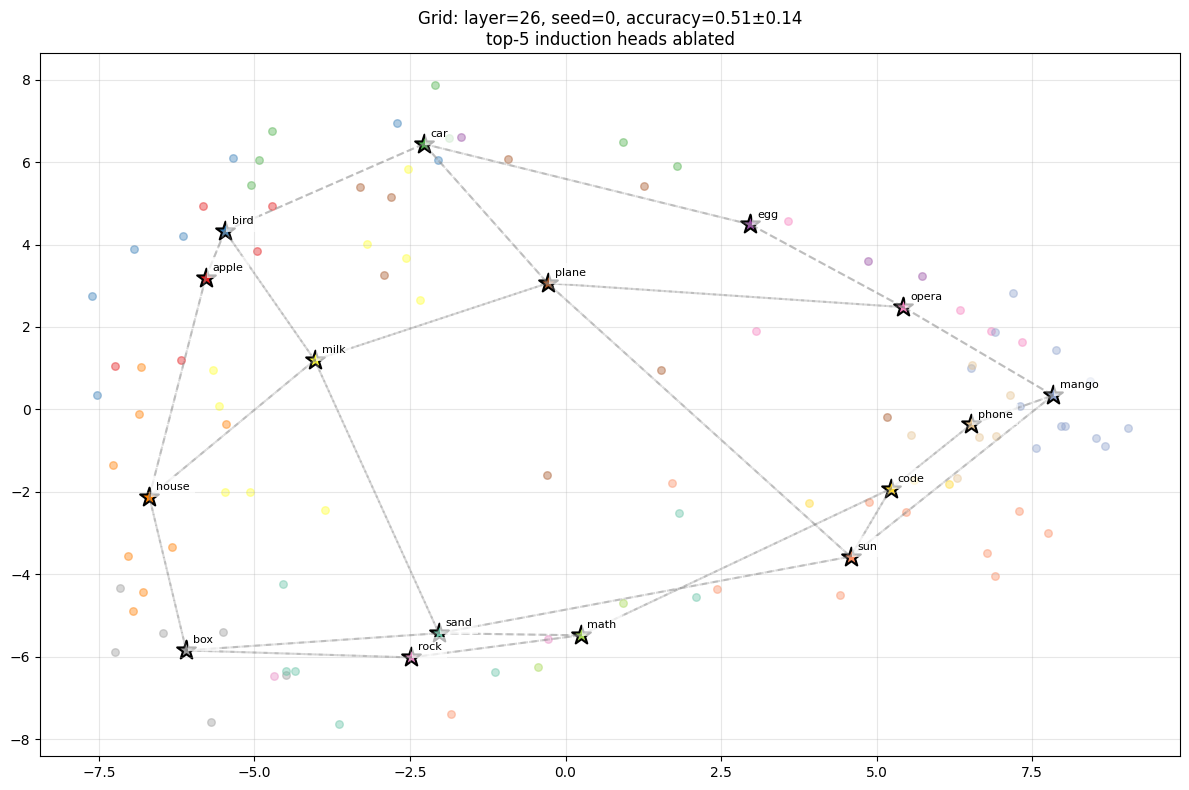

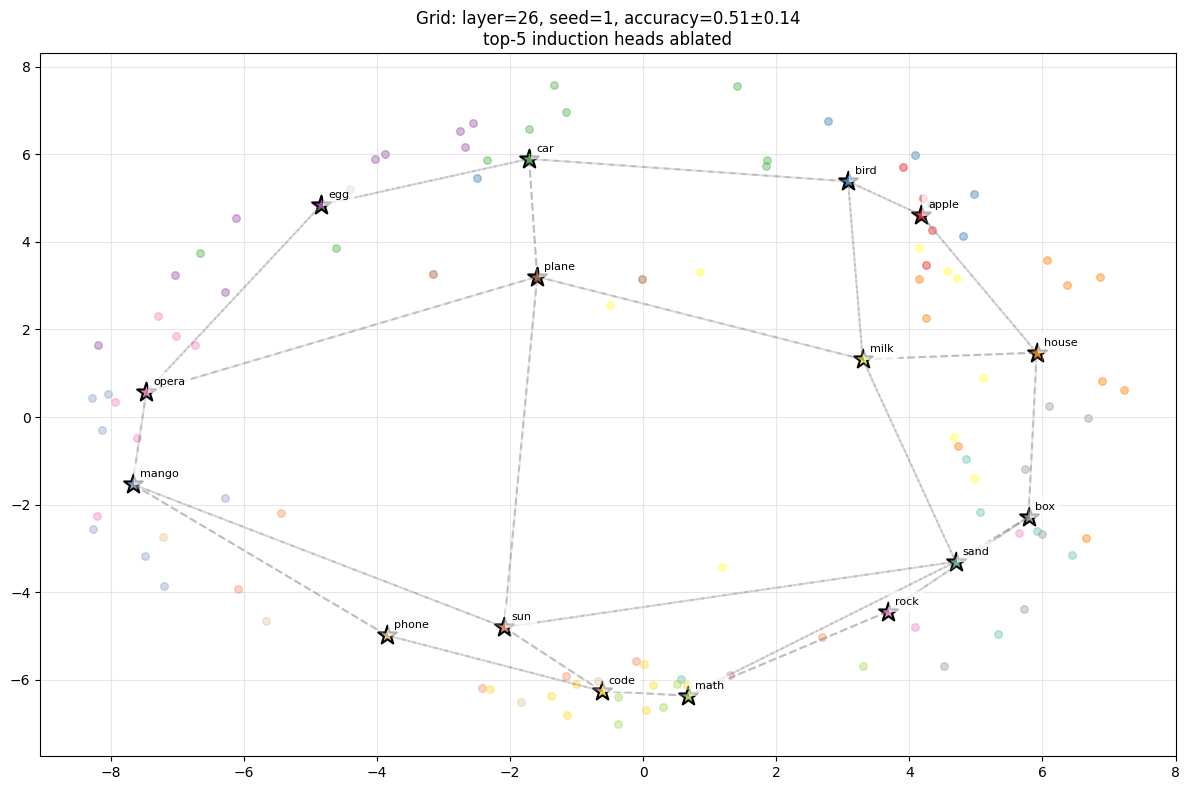

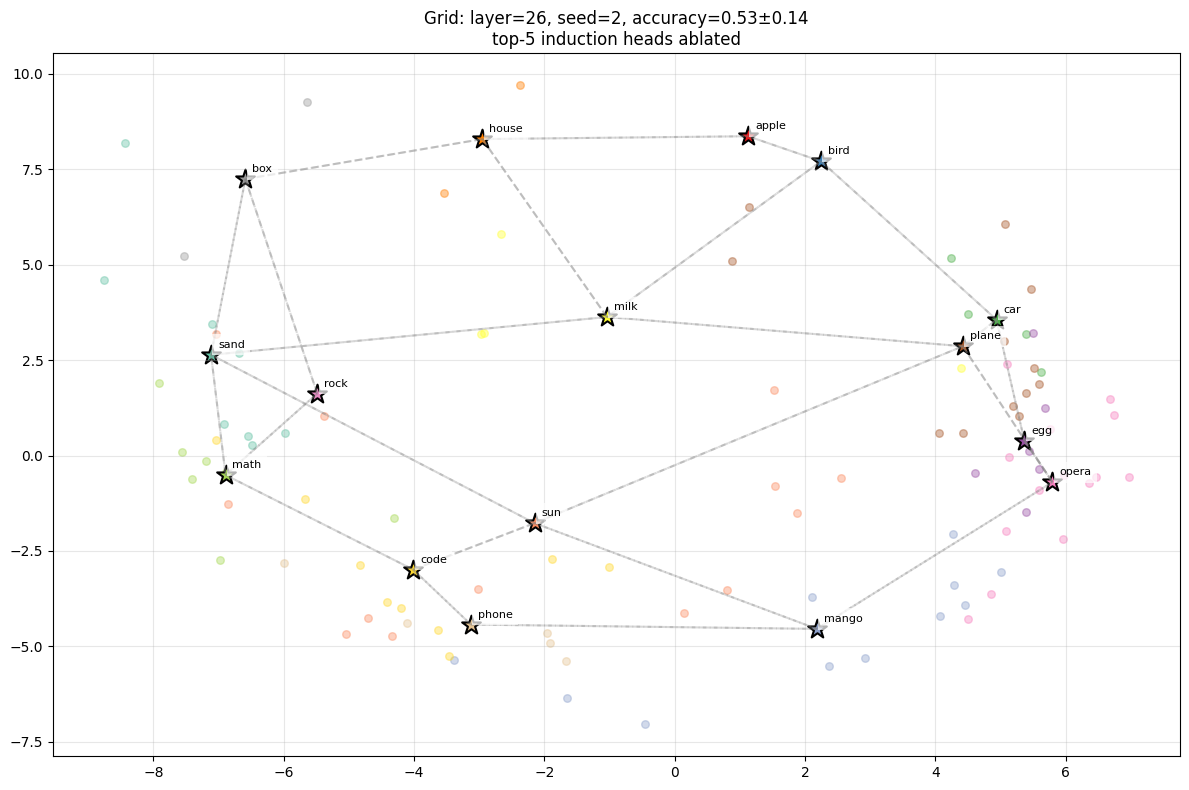

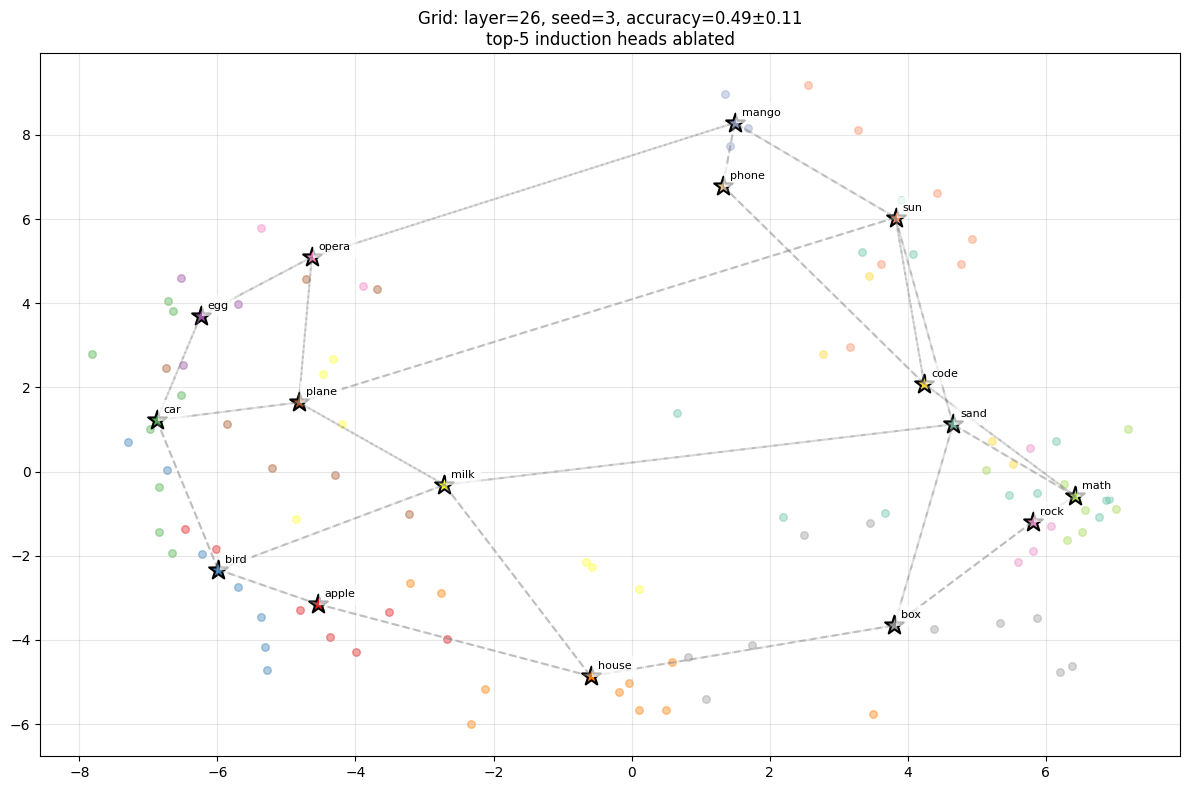

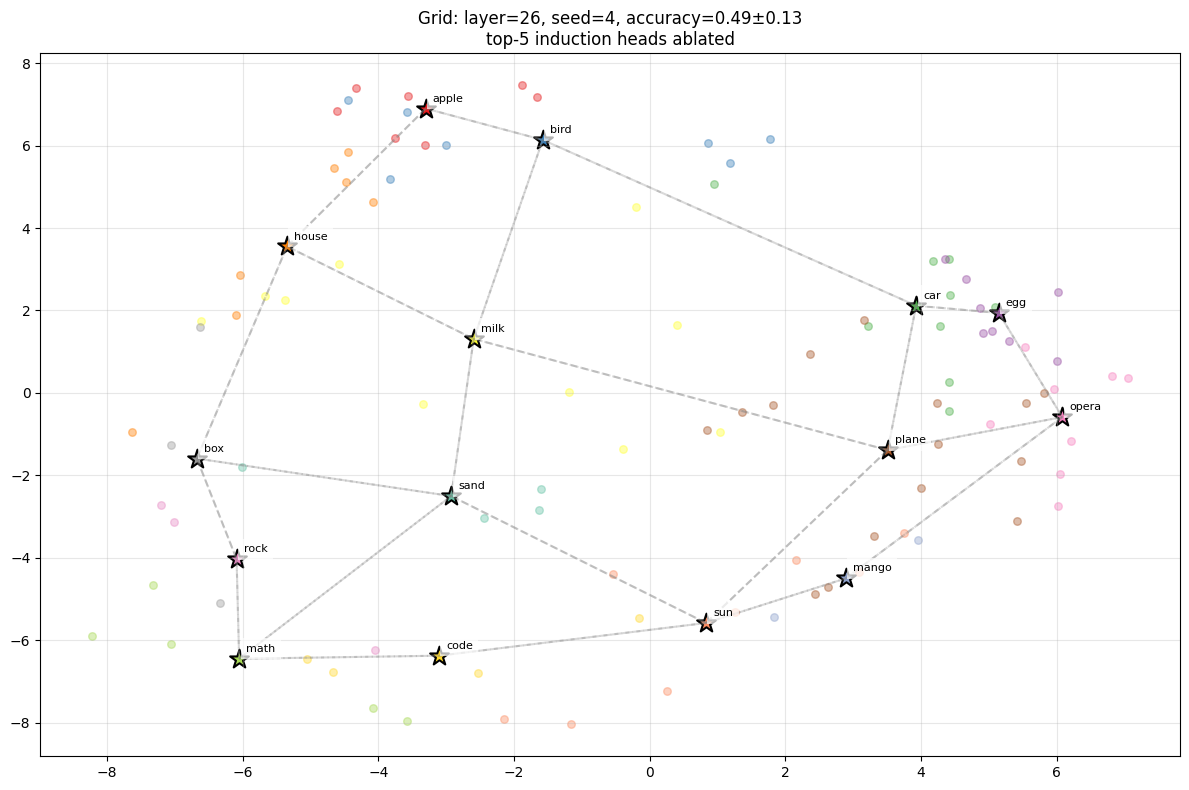

In [67]:
n_lookback = 100
layers = [26]

n_heads_to_ablate = 5
heads_to_ablate = [(layer, head) for _, layer, head in induction_scores_as_list[:n_heads_to_ablate]]
fwd_hooks = [(utils.get_act_name(activation_type, layer), functools.partial(head_ablation_hook, head=head)) for layer, head in heads_to_ablate]

for seed in range(5):
    set_seed(seed)

    sequence = grid.generate_sequence(1400)
    accuracies = np.array(get_model_accuracies(sequence, fwd_hooks=fwd_hooks))

    layer_to_acts = get_activations(sequence, n_lookback=n_lookback, layers=layers, fwd_hooks=fwd_hooks)
    layer_to_pca_directions = {layer: get_pca_directions(acts, top_n=2) for layer, acts in layer_to_acts.items()}

    accuracy_subtitle = f'accuracy={accuracies[-n_lookback:].mean():.2f}±{accuracies[-n_lookback:].std():.2f}'

    for layer in layers:
        visualize_pca(
            sequence, layer_to_acts[layer], layer_to_pca_directions[layer], n_lookback=n_lookback,
            plot_title=f'Grid: layer={layer}, seed={seed}, {accuracy_subtitle}\ntop-{n_heads_to_ablate} induction heads ablated'
        )

## Ablate all but induction heads

In [73]:
SEQ_LEN = 1400
ITERS = 10
SEED = 0

In [74]:
n_heads_to_preserve_list = [1, 2, 3, 5, 10, 20, 256, 1024]

ablation_accuracies = []
all_heads = [(layer, head) for layer in range(model.cfg.n_layers) for head in range(model.cfg.n_heads)]

for n_heads_to_preserve in n_heads_to_preserve_list:
    heads_to_preserve = [(layer, head) for _, layer, head in induction_scores_as_list[:n_heads_to_preserve]]
    heads_to_preserve += [(layer, head) for _, layer, head in previous_token_head_scores_as_list[:n_heads_to_preserve]]

    heads_to_ablate = [(layer, head) for layer, head in all_heads if (layer, head) not in heads_to_preserve]
    fwd_hooks = [(utils.get_act_name(activation_type, layer), functools.partial(head_ablation_hook, head=head)) for layer, head in heads_to_ablate]

    set_seed(SEED)
    accuracies = []
    for iterations in tqdm.tqdm(range(ITERS)):
        accuracies.append(get_model_accuracies(grid.generate_sequence(SEQ_LEN), fwd_hooks=fwd_hooks))

    ablation_accuracies.append(accuracies)


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


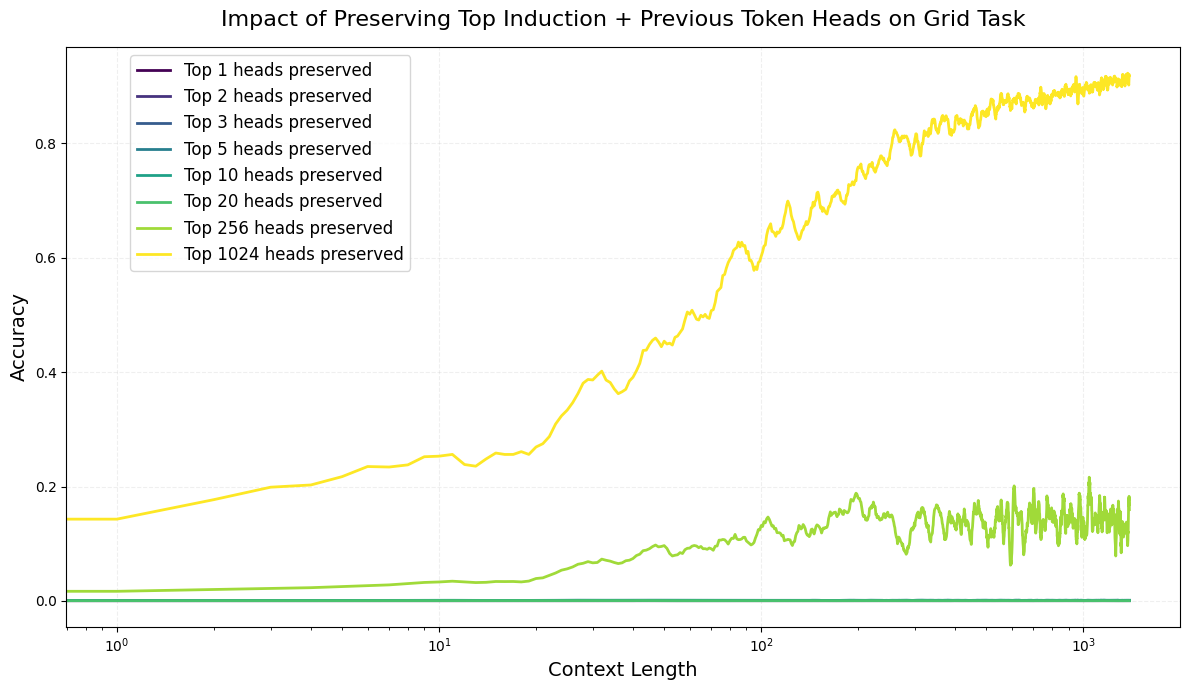

In [75]:
import matplotlib.cm as cm

plt.figure(figsize=(12, 7))

# Create color gradient
colors = cm.viridis(np.linspace(0, 1, len(n_heads_to_preserve_list)))

# Plot each condition
for i, n_heads in enumerate(n_heads_to_preserve_list):
    mean_acc = np.array(ablation_accuracies[i]).mean(axis=0)
    label = 'No ablation' if n_heads == 0 else f'Top {n_heads} heads preserved'
    
    # Apply smoothing
    window = 10
    smoothed = np.convolve(mean_acc, np.ones(window)/window, mode='valid')
    
    plt.plot(smoothed, label=label, color=colors[i], linewidth=2)

plt.xscale('log')
plt.xlabel('Context Length', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Impact of Preserving Top Induction + Previous Token Heads on Grid Task', fontsize=16, pad=15)

# Customize grid
plt.grid(True, alpha=0.2, linestyle='--')

# Move legend outside
plt.legend(fontsize=12, bbox_to_anchor=(0.05, 1), loc='upper left')

# Add some padding to prevent label cutoff
plt.tight_layout()
plt.show()

## Ablate all but induction heads (again)

In [76]:
SEQ_LEN = 1400
ITERS = 10
SEED = 0

In [100]:
# n_heads_to_preserve_list = [1, 2, 3, 5, 10, 20, 256, 1024]

n_heads_to_preserve_list = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256]

layer_cutoff = 6

ablation_accuracies = []
all_heads = [(layer, head) for layer in range(model.cfg.n_layers) for head in range(model.cfg.n_heads)]

for n_heads_to_preserve in n_heads_to_preserve_list:
    induction_scores_as_list_filtered = [(score, layer, head) for score, layer, head in induction_scores_as_list if layer < layer_cutoff]
    previous_token_head_scores_as_list_filtered = [(score, layer, head) for score, layer, head in previous_token_head_scores_as_list if layer < layer_cutoff]

    heads_to_preserve = [(layer, head) for _, layer, head in induction_scores_as_list_filtered[:n_heads_to_preserve]]
    heads_to_preserve += [(layer, head) for _, layer, head in previous_token_head_scores_as_list_filtered[:n_heads_to_preserve]]
    heads_to_preserve += [(layer, head) for layer, head in all_heads if layer in list(range(layer_cutoff, model.cfg.n_layers))]

    heads_to_ablate = [(layer, head) for layer, head in all_heads if (layer, head) not in heads_to_preserve]
    fwd_hooks = [(utils.get_act_name(activation_type, layer), functools.partial(head_ablation_hook, head=head)) for layer, head in heads_to_ablate]

    set_seed(SEED)
    accuracies = []
    for iterations in tqdm.tqdm(range(ITERS)):
        accuracies.append(get_model_accuracies(grid.generate_sequence(SEQ_LEN), fwd_hooks=fwd_hooks))

    ablation_accuracies.append(accuracies)


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


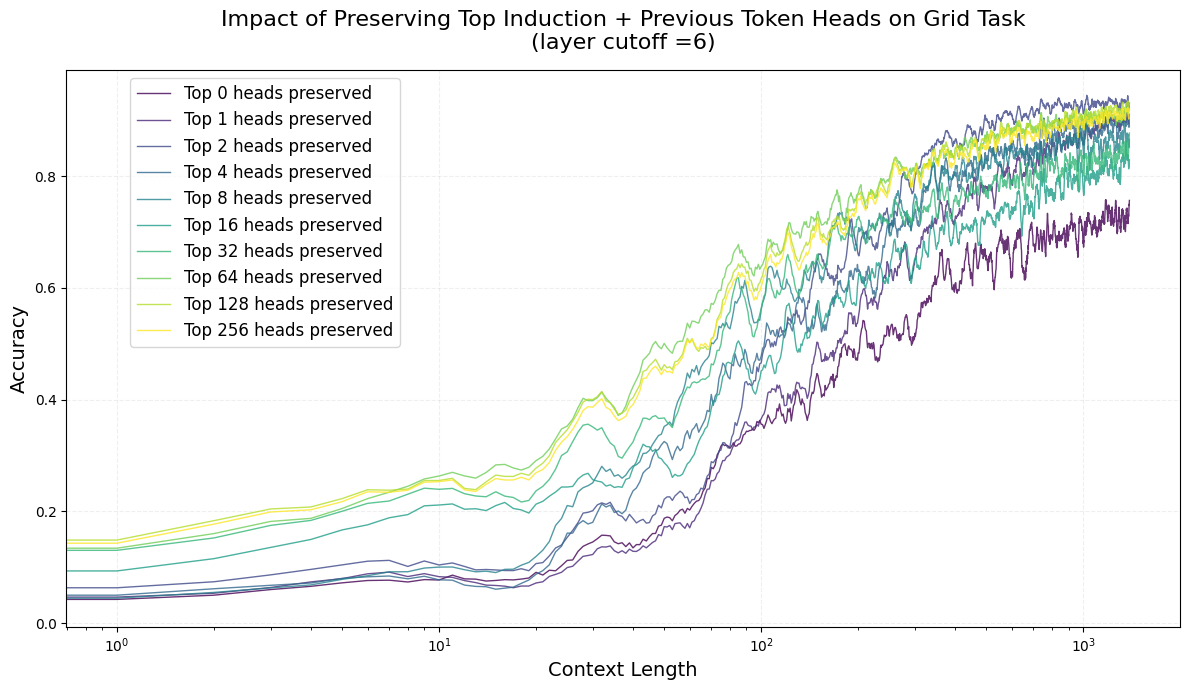

In [106]:
import matplotlib.cm as cm

plt.figure(figsize=(12, 7))

# Create color gradient
colors = cm.viridis(np.linspace(0, 1, len(n_heads_to_preserve_list)))

# Plot each condition
for i, n_heads in enumerate(n_heads_to_preserve_list):
    mean_acc = np.array(ablation_accuracies[i]).mean(axis=0)
    label = f'Top {n_heads} heads preserved'
    
    # Apply smoothing
    window = 10
    smoothed = np.convolve(mean_acc, np.ones(window)/window, mode='valid')
    
    plt.plot(smoothed, label=label, color=colors[i], linewidth=1, alpha=0.8)

plt.xscale('log')
plt.xlabel('Context Length', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title(f'Impact of Preserving Top Induction + Previous Token Heads on Grid Task\n(layer_cutoff ={layer_cutoff})', fontsize=16, pad=15)

# Customize grid
plt.grid(True, alpha=0.2, linestyle='--')

# Move legend outside
plt.legend(fontsize=12, bbox_to_anchor=(0.05, 1), loc='upper left')

# Add some padding to prevent label cutoff
plt.tight_layout()
plt.show()

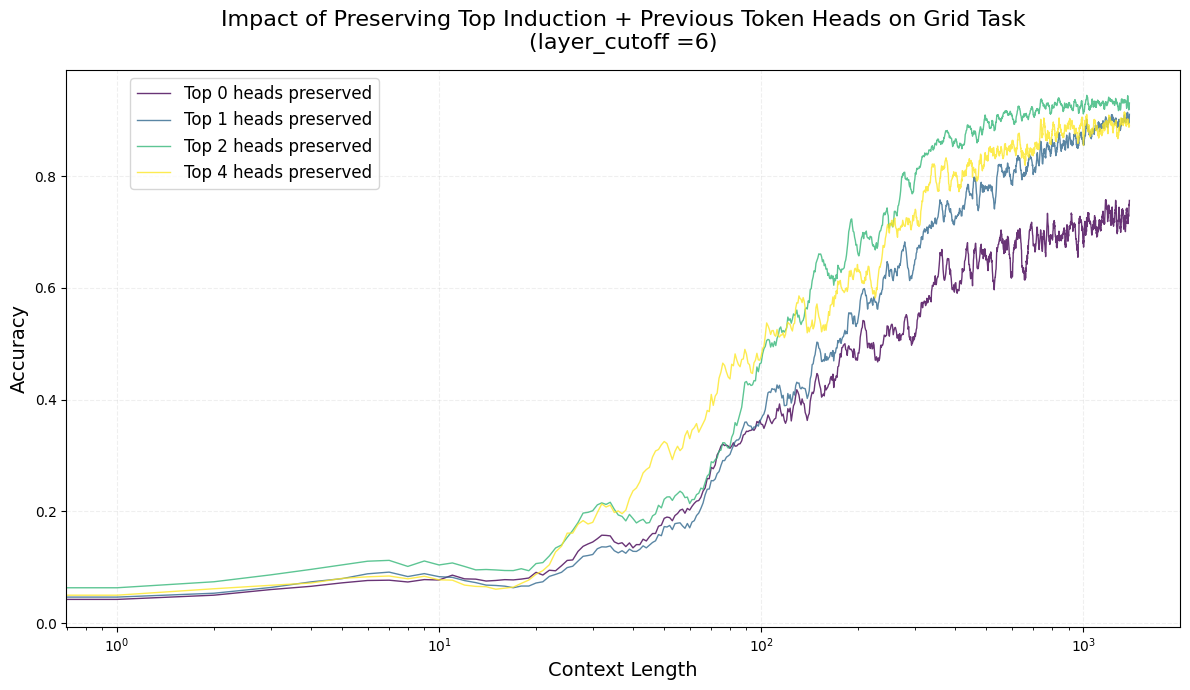

In [107]:
import matplotlib.cm as cm

plt.figure(figsize=(12, 7))

# Create color gradient
colors = cm.viridis(np.linspace(0, 1, len(n_heads_to_preserve_list[:4])))

# Plot each condition
for i, n_heads in enumerate(n_heads_to_preserve_list[:4]):
    mean_acc = np.array(ablation_accuracies[i]).mean(axis=0)
    label = f'Top {n_heads} heads preserved'
    
    # Apply smoothing
    window = 10
    smoothed = np.convolve(mean_acc, np.ones(window)/window, mode='valid')
    
    plt.plot(smoothed, label=label, color=colors[i], linewidth=1, alpha=0.8)

plt.xscale('log')
plt.xlabel('Context Length', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title(f'Impact of Preserving Top Induction + Previous Token Heads on Grid Task\n(layer_cutoff ={layer_cutoff})', fontsize=16, pad=15)

# Customize grid
plt.grid(True, alpha=0.2, linestyle='--')

# Move legend outside
plt.legend(fontsize=12, bbox_to_anchor=(0.05, 1), loc='upper left')

# Add some padding to prevent label cutoff
plt.tight_layout()
plt.show()

Interpreting the above plot:
- If we ablate **all heads in the first 6 layers** except for the top-2 induction heads and top-2 previous-token heads, we recover full performance.

In [108]:
# n_heads_to_preserve_list = [1, 2, 3, 5, 10, 20, 256, 1024]

n_heads_to_preserve_list = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256]

layer_cutoff = 8

ablation_accuracies = []
all_heads = [(layer, head) for layer in range(model.cfg.n_layers) for head in range(model.cfg.n_heads)]

for n_heads_to_preserve in n_heads_to_preserve_list:
    induction_scores_as_list_filtered = [(score, layer, head) for score, layer, head in induction_scores_as_list if layer < layer_cutoff]
    previous_token_head_scores_as_list_filtered = [(score, layer, head) for score, layer, head in previous_token_head_scores_as_list if layer < layer_cutoff]

    heads_to_preserve = [(layer, head) for _, layer, head in induction_scores_as_list_filtered[:n_heads_to_preserve]]
    heads_to_preserve += [(layer, head) for _, layer, head in previous_token_head_scores_as_list_filtered[:n_heads_to_preserve]]
    heads_to_preserve += [(layer, head) for layer, head in all_heads if layer in list(range(layer_cutoff, model.cfg.n_layers))]

    heads_to_ablate = [(layer, head) for layer, head in all_heads if (layer, head) not in heads_to_preserve]
    fwd_hooks = [(utils.get_act_name(activation_type, layer), functools.partial(head_ablation_hook, head=head)) for layer, head in heads_to_ablate]

    set_seed(SEED)
    accuracies = []
    for iterations in tqdm.tqdm(range(ITERS)):
        accuracies.append(get_model_accuracies(grid.generate_sequence(SEQ_LEN), fwd_hooks=fwd_hooks))

    ablation_accuracies.append(accuracies)


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


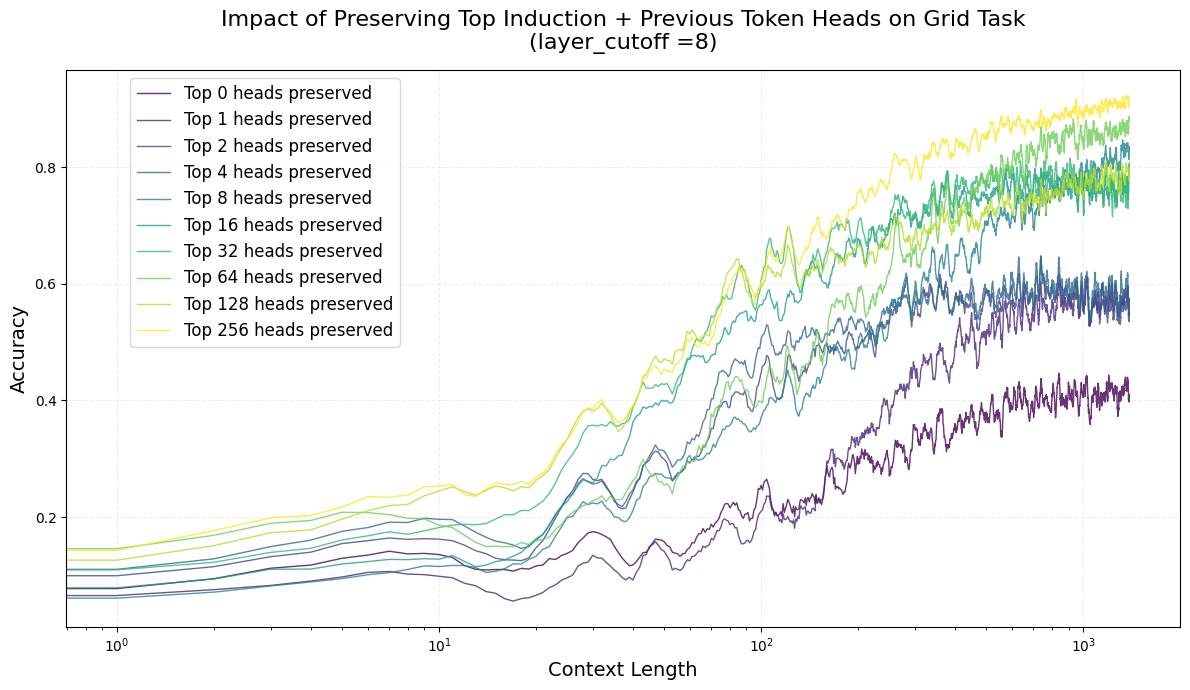

In [109]:
import matplotlib.cm as cm

plt.figure(figsize=(12, 7))

# Create color gradient
colors = cm.viridis(np.linspace(0, 1, len(n_heads_to_preserve_list)))

# Plot each condition
for i, n_heads in enumerate(n_heads_to_preserve_list):
    mean_acc = np.array(ablation_accuracies[i]).mean(axis=0)
    label = f'Top {n_heads} heads preserved'
    
    # Apply smoothing
    window = 10
    smoothed = np.convolve(mean_acc, np.ones(window)/window, mode='valid')
    
    plt.plot(smoothed, label=label, color=colors[i], linewidth=1, alpha=0.8)

plt.xscale('log')
plt.xlabel('Context Length', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title(f'Impact of Preserving Top Induction + Previous Token Heads on Grid Task\n(layer_cutoff ={layer_cutoff})', fontsize=16, pad=15)

# Customize grid
plt.grid(True, alpha=0.2, linestyle='--')

# Move legend outside
plt.legend(fontsize=12, bbox_to_anchor=(0.05, 1), loc='upper left')

# Add some padding to prevent label cutoff
plt.tight_layout()
plt.show()

In [110]:
# n_heads_to_preserve_list = [1, 2, 3, 5, 10, 20, 256, 1024]

n_heads_to_preserve_list = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256]

layer_cutoff = 10

ablation_accuracies = []
all_heads = [(layer, head) for layer in range(model.cfg.n_layers) for head in range(model.cfg.n_heads)]

for n_heads_to_preserve in n_heads_to_preserve_list:
    induction_scores_as_list_filtered = [(score, layer, head) for score, layer, head in induction_scores_as_list if layer < layer_cutoff]
    previous_token_head_scores_as_list_filtered = [(score, layer, head) for score, layer, head in previous_token_head_scores_as_list if layer < layer_cutoff]

    heads_to_preserve = [(layer, head) for _, layer, head in induction_scores_as_list_filtered[:n_heads_to_preserve]]
    heads_to_preserve += [(layer, head) for _, layer, head in previous_token_head_scores_as_list_filtered[:n_heads_to_preserve]]
    heads_to_preserve += [(layer, head) for layer, head in all_heads if layer in list(range(layer_cutoff, model.cfg.n_layers))]

    heads_to_ablate = [(layer, head) for layer, head in all_heads if (layer, head) not in heads_to_preserve]
    fwd_hooks = [(utils.get_act_name(activation_type, layer), functools.partial(head_ablation_hook, head=head)) for layer, head in heads_to_ablate]

    set_seed(SEED)
    accuracies = []
    for iterations in tqdm.tqdm(range(ITERS)):
        accuracies.append(get_model_accuracies(grid.generate_sequence(SEQ_LEN), fwd_hooks=fwd_hooks))

    ablation_accuracies.append(accuracies)


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


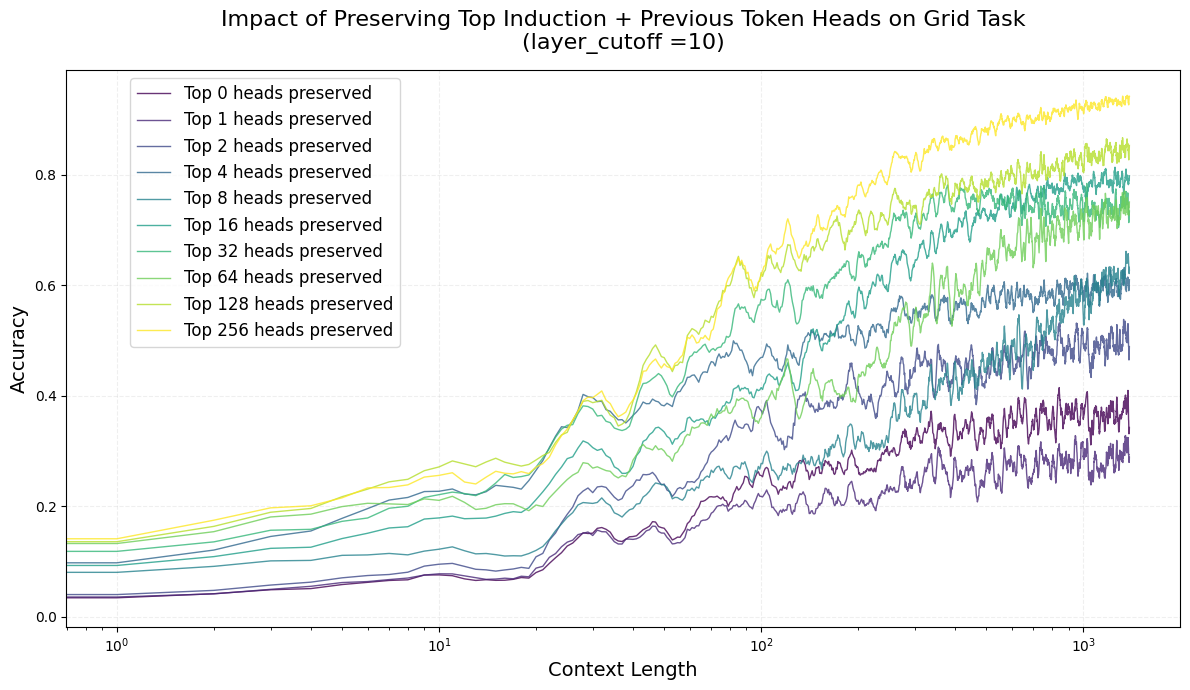

In [111]:
import matplotlib.cm as cm

plt.figure(figsize=(12, 7))

# Create color gradient
colors = cm.viridis(np.linspace(0, 1, len(n_heads_to_preserve_list)))

# Plot each condition
for i, n_heads in enumerate(n_heads_to_preserve_list):
    mean_acc = np.array(ablation_accuracies[i]).mean(axis=0)
    label = f'Top {n_heads} heads preserved'
    
    # Apply smoothing
    window = 10
    smoothed = np.convolve(mean_acc, np.ones(window)/window, mode='valid')
    
    plt.plot(smoothed, label=label, color=colors[i], linewidth=1, alpha=0.8)

plt.xscale('log')
plt.xlabel('Context Length', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title(f'Impact of Preserving Top Induction + Previous Token Heads on Grid Task\n(layer_cutoff ={layer_cutoff})', fontsize=16, pad=15)

# Customize grid
plt.grid(True, alpha=0.2, linestyle='--')

# Move legend outside
plt.legend(fontsize=12, bbox_to_anchor=(0.05, 1), loc='upper left')

# Add some padding to prevent label cutoff
plt.tight_layout()
plt.show()

I think we're missing something here.

Induction heads seem like the critical heads in the first ~6 layers.

But after this, it seems like something else might be going on?